In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
# Directory with our training good pictures
train_good_dir = os.path.join('ImgC/train/good')

# Directory with our training bad pictures
train_bad_dir = os.path.join('ImgC/train/bad')

# Directory with our validation good pictures
valid_good_dir = os.path.join('ImgC//test/good')

# Directory with our validation bad pictures
valid_bad_dir = os.path.join('ImgC/test/bad')

In [5]:
train_good_names = os.listdir(train_good_dir)
print(train_good_names[:5])

train_bad_names = os.listdir(train_bad_dir)
print(train_bad_names[:5])

validation_good_names = os.listdir(valid_good_dir)
print(validation_good_names[:5])

validation_bad_names = os.listdir(valid_bad_dir)
print(validation_bad_names[:5])

['PE170DL70P-30-C(Security-C)_7_4.png', 'PE170DL70P-03-C(Security-C)_24_7.png', 'PE170DL70P-01-C(Security-C)_33_8.png', 'PE170DL70P-27-C(Security-C)_10_9.png', 'PE170DL70P-03-C(Security-C)_12_4.png']
['PE170DL70P-19-C(Security-C)_17_3.png', 'PE170DL70P-29-C(Security-C)_24_9.png', 'PE170DL70P-17-C(Security-C)_29_2.png', 'PE170DL70P-30-C(Security-C)_32_6.png', 'PE170DL70P-10-C(Security-C)_3_8.png']
['PE170DL70P-09-C(Security-C)_4_8.png', 'PE170DL70P-07-C(Security-C)_24_2.png', 'PE170DL70P-07-C(Security-C)_16_8.png', 'PE170DL70P-16-C(Security-C)_14_8.png', 'PE170DL70P-08-C(Security-C)_24_6.png']
['PE170DL70P-13-C(Security-C)_19_4.png', 'PE170DL70P-12-C(Security-C)_23_1.png', 'PE170DL70P-10-C(Security-C)_25_3.png', 'PE170DL70P-18-C(Security-C)_16_3.png', 'PE170DL70P-32-C(Security-C)_21_8.png']


In [29]:
print('total training good images:', len(os.listdir(train_good_dir)))
print('total training bad images:', len(os.listdir(train_bad_dir)))
print('total validation good images:', len(os.listdir(valid_good_dir)))
print('total validation bad images:', len(os.listdir(valid_bad_dir)))

total training good images: 1465
total training bad images: 651
total validation good images: 262
total validation bad images: 114


In [30]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [2]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_good_pic = [os.path.join(train_good_dir, fname) 
                for fname in train_good_names[pic_index-8:pic_index]]
next_bad_pic = [os.path.join(train_bad_dir, fname) 
                for fname in train_bad_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_good_pic + next_bad_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  #plt.imshow(img)

#plt.show()

NameError: name 'plt' is not defined

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1/255,
                                       shear_range = 0.15,
                                        zoom_range = 0.15,
                                   horizontal_flip = True)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'ImgC/train/',  # This is the source directory for training images
        classes = ['good', 'bad'],
        target_size=(74, 74),  # All images will be resized to 74x74
        batch_size=40,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'ImgC/test/',  # This is the source directory for training images
        classes = ['good', 'bad'],
        target_size=(74, 74),  # All images will be resized to 74x74
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 2115 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


In [64]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (74,74,3)), 
                                    #tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    #tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    #tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    #tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
                                    ])

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 16428)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               2102912   
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 2,103,041
Trainable params: 2,103,041
Non-trainable params: 0
_________________________________________________________________


In [66]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [67]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=32,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/10
53/53 [==============================] - 4s 82ms/step - loss: 4.8731 - acc: 0.6865 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 2/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9572 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 4.9646 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 4/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9603 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 5/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9593 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 6/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9657 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 7/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9593 - acc: 0.6922 - val_loss: 5.0051 - val_acc: 0.6968
Epoch 8/10
53/53 [==============================] - 4s 80ms/step - loss: 4.9614 - a

In [63]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

20/20 [==============================] - 1s 38ms/step


In [38]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

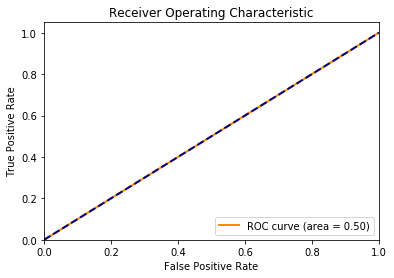

In [39]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()